In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

gdp_df = pd.read_excel("jan-28-gdp.xlsx", sheet_name=0, header=None)
gini_df1 = pd.read_excel("dec-30-gini.xlsx", sheet_name=0)
gini_raw2 = pd.read_excel("new-jan-11-extra-gini.xlsx", sheet_name=0)

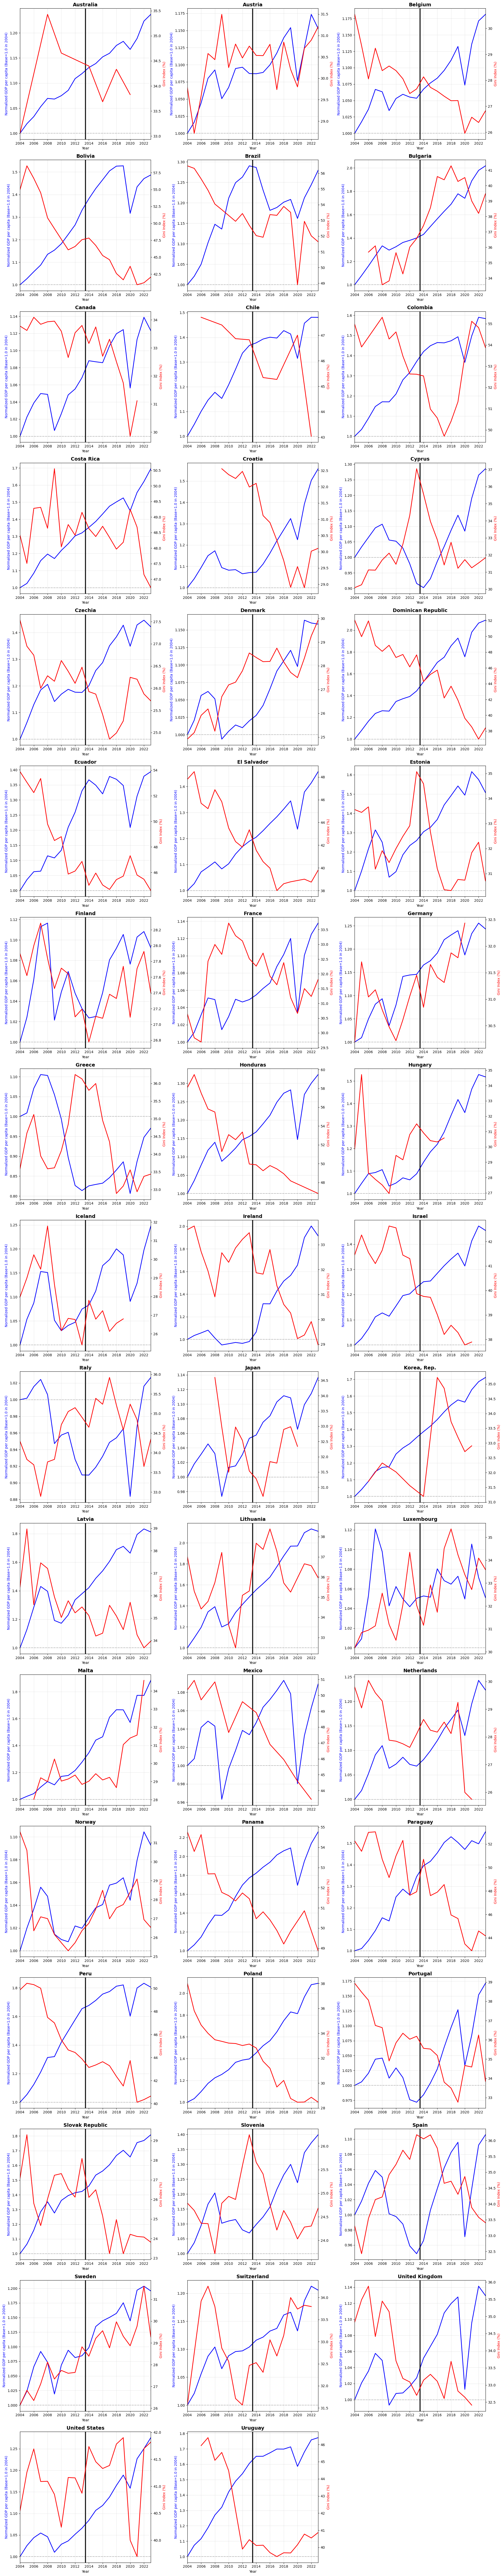

In [34]:
# country subplots for Gini and GDP data



gdp_df.columns = gdp_df.iloc[1]
gdp_df = gdp_df[2:].reset_index(drop=True)
gdp_long = pd.melt(gdp_df, id_vars=["Country Name"], var_name="year", value_name="gdp")
gdp_long["year"] = gdp_long["year"].astype(str).str.extract(r"(\d{4})").astype(int)
gdp_long["gdp"] = pd.to_numeric(gdp_long["gdp"], errors="coerce")
gdp_long = gdp_long.dropna(subset=["gdp", "year"])
gdp_long = gdp_long.drop_duplicates(subset=["Country Name", "year"], keep="last")

gini_df1.columns = gini_df1.iloc[0]
gini_df1 = gini_df1[1:].reset_index(drop=True)
gini_df1.columns = ["country", "year", "gini"]
gini_df1["year"] = pd.to_numeric(gini_df1["year"], errors="coerce")
gini_df1["gini"] = pd.to_numeric(gini_df1["gini"], errors="coerce")
gini_df1 = gini_df1.dropna(subset=["country", "year", "gini"])
gini_df1["year"] = gini_df1["year"].astype(int)

gini_df2 = gini_raw2.rename(columns={"Table 1": "country", "Unnamed: 1": "year", "Unnamed: 4": "gini"})[["country", "year", "gini"]]
gini_df2["year"] = pd.to_numeric(gini_df2["year"], errors="coerce")
gini_df2["gini"] = pd.to_numeric(gini_df2["gini"], errors="coerce")
gini_df2 = gini_df2.dropna(subset=["country", "year", "gini"])
gini_df2["year"] = gini_df2["year"].astype(int)

gini_df = pd.concat([gini_df1, gini_df2], ignore_index=True)
gini_df = gini_df.drop_duplicates(subset=["country", "year"], keep="last")

start_year_min = 2004
end_year_cap = 2023
vline_year = 2013.5

gdp_base = (gdp_long[gdp_long["year"].eq(start_year_min)]
            .set_index("Country Name")["gdp"])

countries = sorted(set(gdp_base.index).intersection(set(gini_df["country"])))

n = len(countries)
cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, 6 * rows))
axes = np.array(axes).ravel()

for i, country in enumerate(countries):
    gdp_country = gdp_long[(gdp_long["Country Name"] == country) & (gdp_long["year"].between(start_year_min, end_year_cap))].sort_values("year")
    gini_country = gini_df[(gini_df["country"] == country) & (gini_df["year"].between(start_year_min, end_year_cap))].sort_values("year")

    ax = axes[i]

    base_gdp = float(gdp_base.loc[country])
    if pd.isna(base_gdp) or base_gdp == 0:
        ax.set_title(country, fontsize=14, fontweight="bold")
        ax.axis("off")
        continue

    gdp_country = gdp_country.copy()
    gdp_country["gdp_norm"] = gdp_country["gdp"].astype(float) / base_gdp

    ax.plot(gdp_country["year"], gdp_country["gdp_norm"], "b-", linewidth=2)
    ax_twin = ax.twinx()
    ax_twin.plot(gini_country["year"], gini_country["gini"] * 100, "r-", linewidth=2)

    ax.axhline(1.0, color="gray", linestyle="--", alpha=0.5)

    ax.set_title(f"{country}", fontsize=14, fontweight="bold")
    ax.set_xlabel("Year")
    ax.set_ylabel("Normalized GDP per capita (Base=1.0 in 2004)", color="b")
    ax_twin.set_ylabel("Gini Index (%)", color="r")

    ax.grid(True, alpha=0.3)
    ax.set_xlim(start_year_min, end_year_cap)

    step = 2 if (end_year_cap - start_year_min) <= 30 else 5
    ax.set_xticks(list(range(start_year_min, end_year_cap + 1, step)))

    ax.axvline(vline_year, color="black", linewidth=3, alpha=0.9)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()




In [ ]:
# same code as above but organizing subplots into a folder

import matplotlib.pyplot as plt
import numpy as np
import os
import re

start_year_min, end_year_cap, vline_year = 2004, 2023, 2013.5
out_dir = "country-subplots-new"
os.makedirs(out_dir, exist_ok=True)

gdp_base = (gdp_long[gdp_long["year"].eq(start_year_min)]
            .set_index("Country Name")["gdp"])

countries = sorted(set(gdp_base.index).intersection(set(gini_df["country"])))

for country in countries:
    g = gdp_long[(gdp_long["Country Name"] == country) & (gdp_long["year"].between(start_year_min, end_year_cap))].sort_values("year")
    h = gini_df[(gini_df["country"] == country) & (gini_df["year"].between(start_year_min, end_year_cap))].sort_values("year")
    if h.empty:
        continue

    base_gdp = float(gdp_base.loc[country])
    if not np.isfinite(base_gdp) or base_gdp == 0:
        continue

    g = g.copy()
    g["gdp_norm"] = g["gdp"].to_numpy(float) / base_gdp

    fig, ax = plt.subplots(figsize=(7, 5))
    ax2 = ax.twinx()

    ax.plot(g["year"], g["gdp_norm"], "b-", lw=2)
    ax2.plot(h["year"], h["gini"].to_numpy(float) * 100.0, "r-", lw=2)

    ax.axhline(1.0, color="gray", ls="--", alpha=0.5)
    ax.axvline(vline_year, color="black", lw=3, alpha=0.9)

    ax.set_title(f"{country}", fontsize=14, fontweight="bold")
    ax.set_xlabel("Year")
    ax.set_ylabel("Normalized GDP per capita (Base=1.0 in 2004)", color="b")
    ax2.set_ylabel("Gini Index (%)", color="r")
    ax.grid(True, alpha=0.3)
    ax.set_xlim(start_year_min, end_year_cap)

    step = 2 if (end_year_cap - start_year_min) <= 30 else 5
    ax.set_xticks(list(range(start_year_min, end_year_cap + 1, step)))

    safe_country = re.sub(r'[\\/*?:"<>|]+', "_", country).strip()
    fig.tight_layout()
    fig.savefig(os.path.join(out_dir, f"{safe_country}.png"), dpi=200)
    plt.close(fig)



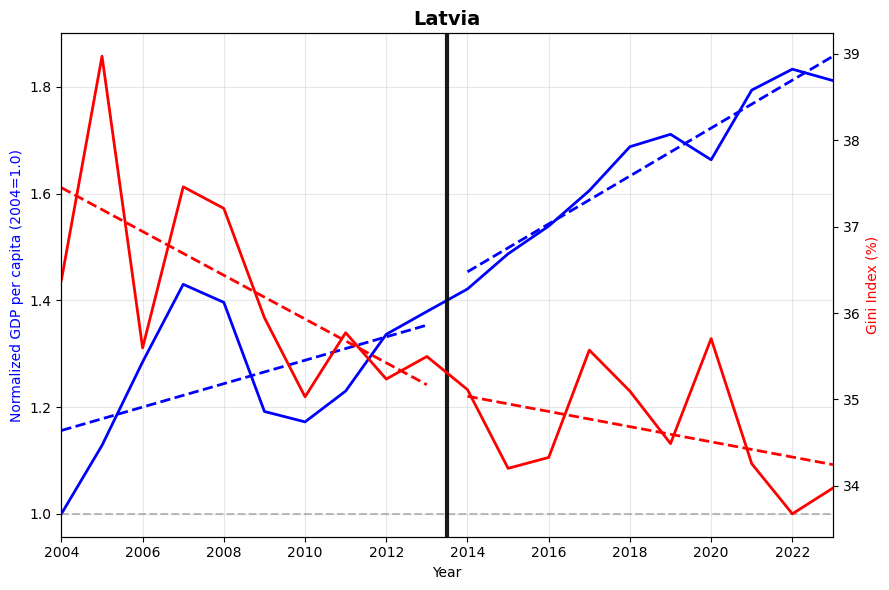

For 2004–2013: a1=0.022, b1=-42.798, c1=-0.253, d1=545.206
For 2014–2023: a2=0.045, b2=-88.964, c2=-0.088, d2=212.142


In [60]:
# choosing one country in specific (Latvia) to see slope visualization


import matplotlib.pyplot as plt
import numpy as np

country = "Latvia"
start_year_min, end_year_cap, vline_year = 2004, 2023, 2013.5

g = gdp_long[gdp_long["Country Name"].eq(country) & gdp_long["year"].between(start_year_min, end_year_cap)].sort_values("year").copy()
h = gini_df[gini_df["country"].eq(country) & gini_df["year"].between(start_year_min, end_year_cap)].sort_values("year").copy()

base_year = int(g["year"].iloc[0])
base_gdp = float(g["gdp"].iloc[0])

g["gdp_norm"] = g["gdp"].to_numpy(float) / base_gdp
h["gini_pct"] = h["gini"].to_numpy(float) * 100.0

h_years = set(h["year"].to_list())

g1 = g[g["year"].between(2004, 2013) & g["year"].isin(h_years)]
g2 = g[g["year"].between(2014, 2023) & g["year"].isin(h_years)]
h1 = h[h["year"].between(2004, 2013)]
h2 = h[h["year"].between(2014, 2023)]

t1g, y1g = g1["year"].to_numpy(float), g1["gdp_norm"].to_numpy(float)
t2g, y2g = g2["year"].to_numpy(float), g2["gdp_norm"].to_numpy(float)
t1h, y1h = h1["year"].to_numpy(float), h1["gini_pct"].to_numpy(float)
t2h, y2h = h2["year"].to_numpy(float), h2["gini_pct"].to_numpy(float)

a1, b1 = np.polyfit(t1g, y1g, 1) if len(t1g) >= 2 else (np.nan, np.nan)
a2, b2 = np.polyfit(t2g, y2g, 1) if len(t2g) >= 2 else (np.nan, np.nan)
c1, d1 = np.polyfit(t1h, y1h, 1) if len(t1h) >= 2 else (np.nan, np.nan)
c2, d2 = np.polyfit(t2h, y2h, 1) if len(t2h) >= 2 else (np.nan, np.nan)

fig, ax = plt.subplots(figsize=(9, 6))
ax2 = ax.twinx()

ax.plot(g["year"], g["gdp_norm"], "b-", lw=2)
ax2.plot(h["year"], h["gini_pct"], "r-", lw=2)

if np.isfinite(a1): ax.plot(t1g, a1*t1g + b1, "b--", lw=2)
if np.isfinite(a2): ax.plot(t2g, a2*t2g + b2, "b--", lw=2)
if np.isfinite(c1): ax2.plot(t1h, c1*t1h + d1, "r--", lw=2)
if np.isfinite(c2): ax2.plot(t2h, c2*t2h + d2, "r--", lw=2)

ax.axhline(1.0, color="gray", ls="--", alpha=0.5)
ax.axvline(vline_year, color="black", lw=3, alpha=0.9)

ax.set_title(f"{country}", fontsize=14, fontweight="bold")
ax.set_xlabel("Year")
ax.set_ylabel("Normalized GDP per capita (2004=1.0)", color="b")
ax2.set_ylabel("Gini Index (%)", color="r")
ax.grid(True, alpha=0.3)
ax.set_xlim(start_year_min, end_year_cap)

step = 2 if (end_year_cap - start_year_min) <= 30 else 5
ax.set_xticks(list(range(start_year_min, end_year_cap + 1, step)))

plt.tight_layout()
plt.show()

print(f"For 2004–2013: a1={a1:.3f}, b1={b1:.3f}, c1={c1:.3f}, d1={d1:.3f}")
print(f"For 2014–2023: a2={a2:.3f}, b2={b2:.3f}, c2={c2:.3f}, d2={d2:.3f}")



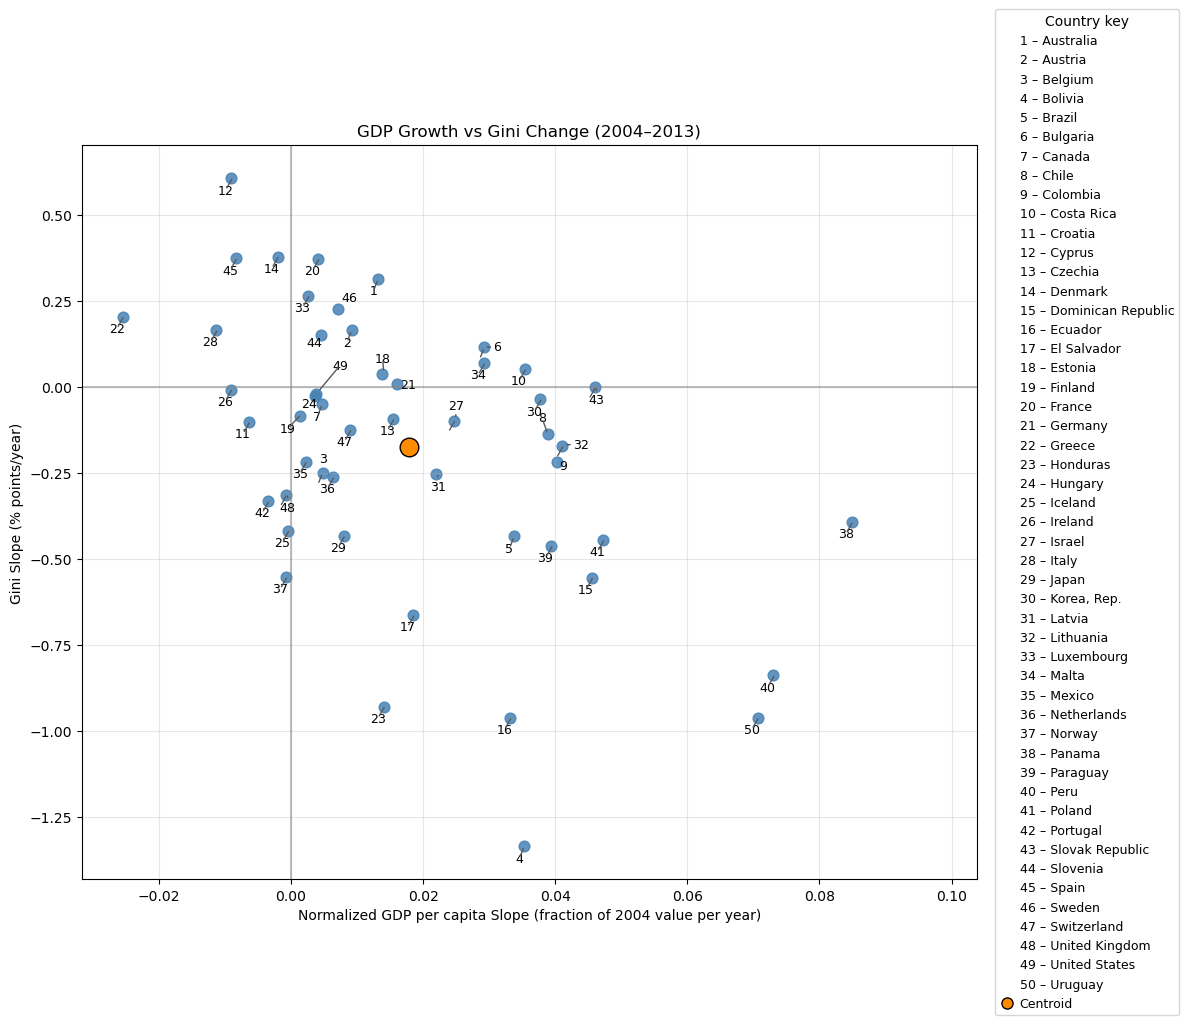

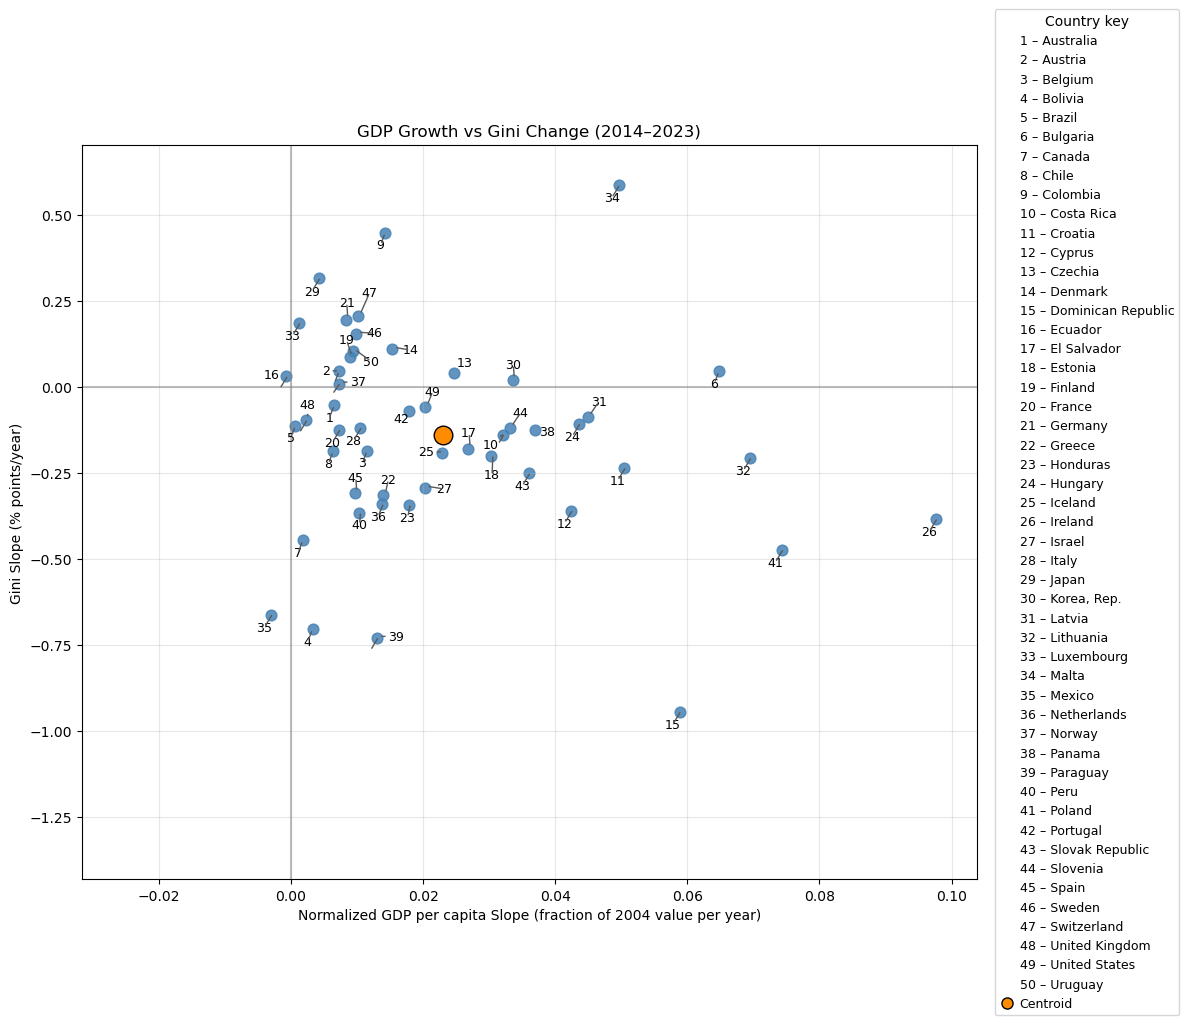

In [ ]:
# calculating slopes for GDP and Gini and then making scatterplots for each decade with orange point as centroid


import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines
from adjustText import adjust_text

countries = sorted(set(gdp_long["Country Name"]).intersection(set(gini_df["country"])))

gdp_base = (
    gdp_long[gdp_long["year"] >= 2004]
    .sort_values(["Country Name", "year"])
    .groupby("Country Name")["gdp"]
    .first()
)

gdp_base_year = (
    gdp_long[gdp_long["year"] >= 2004]
    .sort_values(["Country Name", "year"])
    .groupby("Country Name")["year"]
    .first()
)

def slopes_for_window(country, y0, y1):
    g = gdp_long[(gdp_long["Country Name"] == country) & (gdp_long["year"].between(y0, y1))].sort_values("year")
    h = gini_df[(gini_df["country"] == country) & (gini_df["year"].between(y0, y1))].sort_values("year")
    if len(h) < 3 or country not in gdp_base.index:
        return None
    base_gdp = float(gdp_base.loc[country])
    if not np.isfinite(base_gdp) or base_gdp == 0:
        return None
    h_years = set(h["year"].to_list())
    g = g[g["year"].isin(h_years)]
    if len(g) < 3:
        return None
    xg = g["year"].to_numpy(dtype=float)
    yg = g["gdp"].to_numpy(dtype=float) / base_gdp
    xh = h["year"].to_numpy(dtype=float)
    yh = h["gini"].to_numpy(dtype=float) * 100.0
    gdp_slope = np.polyfit(xg, yg, 1)[0]
    gini_slope = np.polyfit(xh, yh, 1)[0]
    return {
        "Country": country,
        "Base_Year_GDP": int(gdp_base_year.loc[country]),
        "End_Year_GDP": int(g["year"].max()),
        "Base_Year_Gini": int(h["year"].min()),
        "End_Year_Gini": int(h["year"].max()),
        "GDP_Slope": float(gdp_slope),
        "Gini_Slope": float(gini_slope),
        "N_years_GDP": int(len(g)),
        "N_years_Gini": int(len(h)),
    }

def build_results(y0, y1):
    out = []
    for c in countries:
        r = slopes_for_window(c, y0, y1)
        if r is not None:
            out.append(r)
    return pd.DataFrame(out).sort_values("Country").reset_index(drop=True)

df_2004_2013 = build_results(2004, 2013)
df_2014_2023 = build_results(2014, 2023)

all_df = pd.concat([df_2004_2013[["GDP_Slope", "Gini_Slope"]], df_2014_2023[["GDP_Slope", "Gini_Slope"]]], ignore_index=True)

xmin, xmax = all_df["GDP_Slope"].min(), all_df["GDP_Slope"].max()
ymin, ymax = all_df["Gini_Slope"].min(), all_df["Gini_Slope"].max()

xpad = 0.05 * (xmax - xmin) if xmax > xmin else 1.0
ypad = 0.05 * (ymax - ymin) if ymax > ymin else 1.0

xlim = (xmin - xpad, xmax + xpad)
ylim = (ymin - ypad, ymax + ypad)

manual_adjustments_2004_2013 = {3: 'top', 27: 'top', 6: 'right', 43: 'down', 48: 'down', 31: 'down', 32: 'right'}
manual_adjustments_2014_2023 = {2: 'left', 39: 'right', 16: 'left', 37: 'right', 10: 'down-left', 48: 'top', 25: 'left'}

no_arrow_2004_2013 = {13, 3, 34}
no_arrow_2014_2023 = {16, 47}

def plot_scatter(df, title, out_path, xlim, ylim, manual_adjustments, no_arrow_labels, s=60):
    dfp = df.sort_values("Country").reset_index(drop=True).copy()
    dfp["ID"] = np.arange(1, len(dfp) + 1)

    mean_x = float(dfp["GDP_Slope"].mean())
    mean_y = float(dfp["Gini_Slope"].mean())

    fig, ax = plt.subplots(figsize=(12, 10))
    ax.scatter(dfp["GDP_Slope"], dfp["Gini_Slope"], s=s, alpha=0.85, color="steelblue")
    ax.scatter([mean_x], [mean_y], s=180, color="darkorange", edgecolor="black", linewidth=1.0, zorder=5)

    ax.set_xlabel("Normalized GDP per capita Slope (fraction of 2004 value per year)")
    ax.set_ylabel("Gini Slope (% points/year)")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.axhline(0, color="gray", linestyle="-", alpha=0.5)
    ax.axvline(0, color="gray", linestyle="-", alpha=0.5)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    texts = []
    texts_single_digit = []
    id_to_text = {}
    for _, row in dfp.iterrows():
        x, y = float(row["GDP_Slope"]), float(row["Gini_Slope"])
        lab = str(int(row["ID"]))
        label_id = int(row["ID"])
        if label_id <= 9:
            t = ax.text(x, y, lab, ha="center", va="center", fontsize=9, color="black")
            texts_single_digit.append(t)
        else:
            t = ax.text(
                x + 0.002*(xlim[1]-xlim[0]),
                y + 0.002*(ylim[1]-ylim[0]),
                lab,
                ha="center",
                va="center",
                fontsize=9,
                color="black"
            )
        texts.append(t)
        id_to_text[label_id] = t

    moved = {id(t): t.get_position() for t in texts}

    adjust_text(
        texts_single_digit,
        ax=ax,
        expand=(1.3, 2.5),
        force_text=(0.8, 1.2),
        force_points=(1.2, 1.6),
        lim=500,
        arrowprops=dict(arrowstyle="-", color="0.35", lw=1.0)
    )

    adjust_text(
        [t for t in texts if t not in texts_single_digit],
        ax=ax,
        expand=(1.15, 2.2),
        force_text=(0.6, 0.9),
        force_points=(1.0, 1.3),
        lim=500,
        arrowprops=dict(arrowstyle="-", color="0.35", lw=1.0)
    )

    for label_id, direction in manual_adjustments.items():
        t = id_to_text[label_id]
        x0, y0 = moved[id(t)]

        if hasattr(t, "arrow_patch") and t.arrow_patch is not None:
            t.arrow_patch.remove()

        offset = 0.01
        if direction == "top":
            new_x, new_y = x0, y0 + offset*(ylim[1]-ylim[0]); t.set_ha("center"); t.set_va("bottom")
        elif direction == "down":
            new_x, new_y = x0, y0 - offset*(ylim[1]-ylim[0]); t.set_ha("center"); t.set_va("top")
        elif direction == "right":
            new_x, new_y = x0 + offset*(xlim[1]-xlim[0]), y0; t.set_ha("left"); t.set_va("center")
        elif direction == "left":
            new_x, new_y = x0 - offset*(xlim[1]-xlim[0]), y0; t.set_ha("right"); t.set_va("center")
        elif direction == "down-left":
            new_x, new_y = (
                x0 - offset*(xlim[1]-xlim[0])*0.707,
                y0 - offset*(ylim[1]-ylim[0])*0.707
            ); t.set_ha("right"); t.set_va("top")

        t.set_position((new_x, new_y))

        if label_id not in no_arrow_labels:
            ax.annotate("", xy=(x0, y0), xytext=(new_x, new_y),
                        arrowprops=dict(arrowstyle="-", color="0.35", lw=1.0))

    fig.canvas.draw()

    for t in texts:
        label_id = next((lid for lid, text_obj in id_to_text.items() if text_obj is t), None)

        if label_id in manual_adjustments:
            continue

        if label_id in no_arrow_labels:
            if hasattr(t, "arrow_patch") and t.arrow_patch is not None:
                t.arrow_patch.set_visible(False)
            continue

        x0, y0 = moved[id(t)]
        x1, y1 = t.get_position()
        p0 = ax.transData.transform((x0, y0))
        p1 = ax.transData.transform((x1, y1))
        if np.hypot(p1[0] - p0[0], p1[1] - p0[1]) < 14:
            if hasattr(t, "arrow_patch") and t.arrow_patch is not None:
                t.arrow_patch.set_visible(False)

        dummy = mlines.Line2D([], [], linestyle="None", marker=None)
        labels = [f"{int(i)} – {c}" for i, c in zip(dfp["ID"], dfp["Country"])]

        mean_handle = mlines.Line2D(
            [], [], color="darkorange", marker="o", linestyle="None",
            markersize=8, markeredgecolor="black", markeredgewidth=1.0
        )

        ax.legend(
            handles=[mean_handle] + [dummy] * len(labels),
            labels=["Centroid"] + labels,
            title="Country key",
            loc="center left",
            bbox_to_anchor=(1.02, 0.5),
            frameon=True,
            handlelength=1.2,
            handletextpad=0.4,
            borderaxespad=0.0,
            fontsize=9,
            title_fontsize=10
        )

    plt.tight_layout()
    plt.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.show()
    plt.close(fig)

    return dfp

key_2004_2013 = plot_scatter(df_2004_2013, "GDP Growth vs Gini Change (2004–2013)", "scatter_2004_2013.png", xlim, ylim, manual_adjustments_2004_2013, no_arrow_2004_2013, s=60)
key_2014_2023 = plot_scatter(df_2014_2023, "GDP Growth vs Gini Change (2014–2023)", "scatter_2014_2023.png", xlim, ylim, manual_adjustments_2014_2023, no_arrow_2014_2023, s=60)


In [44]:
# getting coordinates (for the slope values) from the scatterplot above

import pandas as pd
import numpy as np

def add_id_if_missing(df):
    df2 = df.copy()
    if "ID" not in df2.columns:
        df2 = df2.sort_values("Country").reset_index(drop=True)
        df2["ID"] = np.arange(1, len(df2) + 1)
    return df2

a = add_id_if_missing(df_2004_2013)[["ID", "Country", "GDP_Slope", "Gini_Slope"]].rename(
    columns={"GDP_Slope": "GDP_Slope_2004_2013", "Gini_Slope": "Gini_Slope_2004_2013"}
)

b = add_id_if_missing(df_2014_2023)[["ID", "Country", "GDP_Slope", "Gini_Slope"]].rename(
    columns={"GDP_Slope": "GDP_Slope_2014_2023", "Gini_Slope": "Gini_Slope_2014_2023"}
)

wide = pd.merge(a, b, on=["ID", "Country"], how="outer").sort_values("ID").reset_index(drop=True)

wide_rounded = wide.copy()
cols = ["GDP_Slope_2004_2013", "Gini_Slope_2004_2013", "GDP_Slope_2014_2023", "Gini_Slope_2014_2023"]
wide_rounded[cols] = wide_rounded[cols].round(3)

wide.to_excel("Data For Paper/country_coordinates_wide.xlsx", index=False)
wide_rounded.to_excel("Data For Paper/rounded_country_coordinates_wide.xlsx", index=False)

wide, wide_rounded



(    ID             Country  GDP_Slope_2004_2013  Gini_Slope_2004_2013  \
 0    1           Australia             0.013193              0.313458   
 1    2             Austria             0.009185              0.164493   
 2    3             Belgium             0.004778             -0.249438   
 3    4             Bolivia             0.035324             -1.333558   
 4    5              Brazil             0.033784             -0.434124   
 5    6            Bulgaria             0.029274              0.115328   
 6    7              Canada             0.004724             -0.050109   
 7    8               Chile             0.038882             -0.137993   
 8    9            Colombia             0.040204             -0.219665   
 9   10          Costa Rica             0.035400              0.051249   
 10  11             Croatia            -0.006395             -0.102412   
 11  12              Cyprus            -0.009033              0.605315   
 12  13             Czechia           

In [45]:
# calculating quadrant statistics


import pandas as pd
import numpy as np

def add_id_if_missing(df):
    df2 = df.copy()
    if "ID" not in df2.columns:
        df2 = df2.sort_values("Country").reset_index(drop=True)
        df2["ID"] = np.arange(1, len(df2) + 1)
    return df2

def quadrant(x, y):
    if x >= 0 and y >= 0:
        return "I (NE)"
    if x < 0 and y >= 0:
        return "II (NW)"
    if x < 0 and y < 0:
        return "III (SW)"
    return "IV (SE)"

dfA = add_id_if_missing(df_2004_2013)[["Country", "GDP_Slope", "Gini_Slope"]].copy()
dfB = add_id_if_missing(df_2014_2023)[["Country", "GDP_Slope", "Gini_Slope"]].copy()

dfA["Quadrant"] = [quadrant(x, y) for x, y in zip(dfA["GDP_Slope"], dfA["Gini_Slope"])]
dfB["Quadrant"] = [quadrant(x, y) for x, y in zip(dfB["GDP_Slope"], dfB["Gini_Slope"])]

counts_A = dfA["Quadrant"].value_counts().reindex(["I (NE)", "II (NW)", "III (SW)", "IV (SE)"], fill_value=0)
counts_B = dfB["Quadrant"].value_counts().reindex(["I (NE)", "II (NW)", "III (SW)", "IV (SE)"], fill_value=0)

quadrant_counts = pd.DataFrame({
    "Quadrant": ["I (NE)", "II (NW)", "III (SW)", "IV (SE)"],
    "2004-2013": counts_A.values,
    "2014-2023": counts_B.values
})

merged = pd.merge(
    dfA.rename(columns={"GDP_Slope": "GDP_A", "Gini_Slope": "Gini_A", "Quadrant": "Quadrant_A"}),
    dfB.rename(columns={"GDP_Slope": "GDP_B", "Gini_Slope": "Gini_B", "Quadrant": "Quadrant_B"}),
    on="Country",
    how="inner",
)

merged["Moved_Quadrant"] = merged["Quadrant_A"] != merged["Quadrant_B"]
quadrant_moves = merged.loc[merged["Moved_Quadrant"], ["Country", "Quadrant_A", "Quadrant_B"]].sort_values("Country").reset_index(drop=True)

merged["Move_Distance"] = np.sqrt((merged["GDP_B"] - merged["GDP_A"])**2 + (merged["Gini_B"] - merged["Gini_A"])**2)

dramatic_moves = merged.sort_values("Move_Distance", ascending=False)[
    ["Country", "GDP_A", "Gini_A", "Quadrant_A", "GDP_B", "Gini_B", "Quadrant_B", "Move_Distance"]
].head(10).reset_index(drop=True)
dramatic_moves.insert(0, "Rank", range(1, len(dramatic_moves) + 1))

least_dramatic_moves = merged.sort_values("Move_Distance", ascending=True)[
    ["Country", "GDP_A", "Gini_A", "Quadrant_A", "GDP_B", "Gini_B", "Quadrant_B", "Move_Distance"]
].head(10).reset_index(drop=True)
least_dramatic_moves.insert(0, "Rank", range(1, len(least_dramatic_moves) + 1))

quadrant_counts.to_excel("Data for Paper/quadrant_counts.xlsx", index=False)
quadrant_moves.to_excel("Data for Paper/quadrant_moves.xlsx", index=False)
dramatic_moves.to_excel("Data for Paper/dramatic_moves.xlsx", index=False)
least_dramatic_moves.to_excel("Data for Paper/least_dramatic_moves.xlsx", index=False)

print(quadrant_counts)
print(quadrant_moves)
print(dramatic_moves)
print(least_dramatic_moves)


   Quadrant  2004-2013  2014-2023
0    I (NE)         11         15
1   II (NW)          5          1
2  III (SW)          6          1
3   IV (SE)         28         33
           Country Quadrant_A Quadrant_B
0        Australia     I (NE)    IV (SE)
1         Colombia    IV (SE)     I (NE)
2       Costa Rica     I (NE)    IV (SE)
3          Croatia   III (SW)    IV (SE)
4           Cyprus    II (NW)    IV (SE)
5          Czechia    IV (SE)     I (NE)
6          Denmark    II (NW)     I (NE)
7          Ecuador    IV (SE)    II (NW)
8          Estonia     I (NE)    IV (SE)
9          Finland    IV (SE)     I (NE)
10          France     I (NE)    IV (SE)
11          Greece    II (NW)    IV (SE)
12         Iceland   III (SW)    IV (SE)
13         Ireland   III (SW)    IV (SE)
14           Italy    II (NW)    IV (SE)
15           Japan    IV (SE)     I (NE)
16     Korea, Rep.    IV (SE)     I (NE)
17          Mexico    IV (SE)   III (SW)
18          Norway   III (SW)     I (NE)
19        

In [46]:
# saving things from above to latex


def save_latex(df, path, float_format=None):
    tex = df.to_latex(index=False, escape=False, float_format=float_format)
    with open(path, "w", encoding="utf-8") as f:
        f.write(tex)

save_latex(quadrant_counts, "Data for Paper/quadrant_counts.tex")
save_latex(quadrant_moves, "Data for Paper/quadrant_moves.tex")
save_latex(dramatic_moves, "Data for Paper/dramatic_moves.tex", float_format="%.3f")
save_latex(least_dramatic_moves, "Data for Paper/least_dramatic_moves.tex", float_format="%.3f")
save_latex(wide_rounded, "Data for Paper/rounded_coords.tex")




In [47]:
# creating summary table for additional statistics for the slope values



import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist

def summarize_points(df, period_label):
    d = df[["GDP_Slope", "Gini_Slope"]].dropna().astype(float).copy()
    X = d.to_numpy()

    out = {
        "Decade": period_label,
        "Median Normalized GDP Slope": float(d["GDP_Slope"].median()),
        "Median Gini Slope": float(d["Gini_Slope"].median()),
        "Mean Normalized GDP Slope": float(d["GDP_Slope"].mean()),
        "Mean Gini Slope": float(d["Gini_Slope"].mean()),
        "Normalized GDP Slope Standard Deviation": float(d["GDP_Slope"].std(ddof=1)),
        "Gini Slope Standard Deviation": float(d["Gini_Slope"].std(ddof=1)),
        "Average Distance Between Coordinates": float(np.mean(pdist(X, metric="euclidean"))) if len(d) >= 2 else np.nan,
        # "N": int(len(d)),
    }
    return out

summary_table = pd.DataFrame([
    summarize_points(df_2004_2013, "2004-2013"),
    summarize_points(df_2014_2023, "2014-2023"),
])

summary_table[["Median Normalized GDP Slope", "Median Gini Slope", "Mean Normalized GDP Slope", "Mean Gini Slope", "Normalized GDP Slope Standard Deviation", "Gini Slope Standard Deviation", "Average Distance Between Coordinates" ]] = summary_table[["Median Normalized GDP Slope", "Median Gini Slope", "Mean Normalized GDP Slope", "Mean Gini Slope", "Normalized GDP Slope Standard Deviation", "Gini Slope Standard Deviation", "Average Distance Between Coordinates" ]].round(3)

print(summary_table)

summary_table.to_excel("Data For Paper/summary_table.xlsx", index=False)
save_latex(summary_table, "Data for Paper/summary_table.tex")

      Decade  Median Normalized GDP Slope  Median Gini Slope  \
0  2004-2013                        0.011             -0.100   
1  2014-2023                        0.014             -0.122   

   Mean Normalized GDP Slope  Mean Gini Slope  \
0                      0.018           -0.174   
1                      0.023           -0.139   

   Normalized GDP Slope Standard Deviation  Gini Slope Standard Deviation  \
0                                    0.023                          0.394   
1                                    0.022                          0.287   

   Average Distance Between Coordinates  
0                                 0.440  
1                                 0.319  
